# Installation

In [ ]:
!pip install biopython

!wget -qq https://dgl-data.s3-us-west-2.amazonaws.com/dataset/DRKG/drkg.tar.gz
!tar -xf drkg.tar.gz
!rm drkg.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.4 MB/s eta 0:00:00


# Exploratory Data Analysis

In [ ]:
import pandas as pd
df = pd.read_csv('drkg.tsv', delimiter='\t', names=['node_a', 'relation', 'node_b'])
rel_df = pd.read_csv('/content/relation_glossary.tsv', delimiter='\t')

df.head()

,node_a,relation,node_b
0,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2157
1,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::5264
2,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2158
3,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::3309
4,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::28912


In [ ]:
df.shape, rel_df.shape

((5874261, 3), (107, 6))

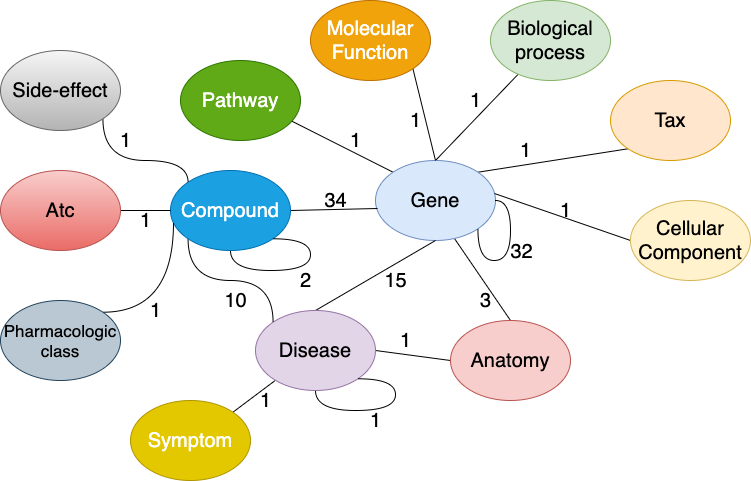

## Relationship Analysis

In [ ]:
set_of_all_nodes = list(set(list(df.node_a) + list(df.node_b)))
set_of_all_node_types = list(set(list(set([node.split("::")[0] for node in list(set(list(df.node_a)))])) + list(set([node.split("::")[0] for node in list(set(list(df.node_b)))]))))
set_of_all_relations = list(set(df.relation))

print(f'# nodes: {len(set_of_all_nodes)}')
print(f'# node-types: {len(set_of_all_node_types)}')
print(f'# relations: {len(list(df.relation))}')
print(f'# relation-types: {len(set_of_all_relations)}\n')

# Gene-Gene Relations
gene2gene = [rel for rel in set_of_all_relations if 'Gene' in rel.split(':')[-2] and 'Gene' in rel.split(':')[-1]]
print(f"# Gene to gene relationship type: {len(gene2gene)}. They are {gene2gene}")

# Drug-Drug Relations
drug2drug = [rel for rel in set_of_all_relations if 'Compound' in rel.split(':')[-2] and 'Compound' in rel.split(':')[-1]]
print(f"# Drug to drug relation type: {len(drug2drug)}. They are {drug2drug}")

# Disease-Disease Relations
dis2dis = [rel for rel in set_of_all_relations if 'Disease' in rel.split(':')[-2] and 'Disease' in rel.split(':')[-1]]
print(f"# Disease to disease relation type: {len(dis2dis)}. They are {dis2dis}")

# Gene-Drug Relations
gene2drug = [rel for rel in set_of_all_relations if 'Compound' in rel.split(':')[-2] and 'Gene' in rel.split(':')[-1]] + [rel for rel in set_of_all_relations if 'Gene' in rel.split(':')[-2] and 'Compound' in rel.split(':')[-1]]
print(f"# Gene to drug relation type: {len(gene2drug)}. They are {gene2drug}")

# Gene-Disease Relations
gene2dis = [rel for rel in set_of_all_relations if 'Disease' in rel.split(':')[-2] and 'Gene' in rel.split(':')[-1]] + [rel for rel in set_of_all_relations if 'Gene' in rel.split(':')[-2] and 'Disease' in rel.split(':')[-1]]
print(f"# Gene to disease relation type: {len(gene2dis)}. They are {gene2dis}")

# Disease-Drug Relations
dis2drug = [rel for rel in set_of_all_relations if 'Disease' in rel.split(':')[-2] and 'Compound' in rel.split(':')[-1]] + [rel for rel in set_of_all_relations if 'Compound' in rel.split(':')[-2] and 'Disease' in rel.split(':')[-1]]
print(f"# Disease to drug relation type: {len(dis2drug)}. They are {dis2drug}")

# nodes: 97238
# node-types: 13
# relations: 5874261
# relation-types: 107

# Gene to gene relationship type: 32. They are ['STRING::OTHER::Gene:Gene', 'bioarx::HumGenHumGen:Gene:Gene', 'STRING::ACTIVATION::Gene:Gene', 'STRING::INHIBITION::Gene:Gene', 'INTACT::PHYSICAL ASSOCIATION::Gene:Gene', 'STRING::REACTION::Gene:Gene', 'GNBR::E+::Gene:Gene', 'INTACT::PHOSPHORYLATION REACTION::Gene:Gene', 'STRING::CATALYSIS::Gene:Gene', 'STRING::PTMOD::Gene:Gene', 'INTACT::DIRECT INTERACTION::Gene:Gene', 'STRING::BINDING::Gene:Gene', 'Hetionet::GiG::Gene:Gene', 'STRING::EXPRESSION::Gene:Gene', 'INTACT::ASSOCIATION::Gene:Gene', 'GNBR::I::Gene:Gene', 'INTACT::UBIQUITINATION REACTION::Gene:Gene', 'GNBR::B::Gene:Gene', 'GNBR::H::Gene:Gene', 'Hetionet::GcG::Gene:Gene', 'GNBR::Q::Gene:Gene', 'bioarx::VirGenHumGen:Gene:Gene', 'INTACT::PROTEIN CLEAVAGE::Gene:Gene', 'Hetionet::Gr>G::Gene:Gene', 'GNBR::V+::Gene:Gene', 'INTACT::COLOCALIZATION::Gene:Gene', 'INTACT::DEPHOSPHORYLATION REACTION::Gene:Gene', 'GNBR

In [ ]:
from collections import Counter

entity_type_a = [rel.split(':')[-2] for rel in df.relation]
entity_type_b = [rel.split(':')[-1] for rel in df.relation]

print(Counter(entity_type_a))
print(Counter(entity_type_b))

Counter({'Gene': 3301947, 'Compound': 1808850, 'Anatomy': 726495, 'Disease': 35940, 'Pharmacologic Class': 1029})
Counter({'Gene': 3290368, 'Compound': 1413076, 'Biological Process': 559504, 'Disease': 179837, 'Side Effect': 138944, 'Molecular Function': 97222, 'Pathway': 84372, 'Cellular Component': 73566, 'Atc': 15750, 'Tax': 14663, 'Anatomy': 3602, 'Symptom': 3357})


In [ ]:
from tqdm import tqdm

entity_type_set_a = list(set(entity_type_a))
entity_type_set_b = list(set(entity_type_b))

relation_counts = {}
for en_a in entity_type_set_a:
    for en_b in entity_type_set_b:
        relation_counts[f"{en_a}-{en_b}"] = 0

sources = []
relation_types = []
relation_entities = []
for idx in tqdm(range(len(df.node_a))):
    relations = df.relation[idx].split(':')
    key = f"{relations[-2]}-{relations[-1]}"
    relation_counts[key] += 1
    sources.append(relations[0])
    relation_types.append(relations[2])
    relation_entities.append(key)

df["relation_entities"] = relation_entities
df["relation_type"] = relation_types
df["source"] = sources

df.drop("relation", inplace=True, axis=1)

100%|██████████| 5874261/5874261 [01:31<00:00, 64552.01it/s]


In [ ]:
valid_counts = {}
for k in relation_counts.keys():
    if relation_counts[k]:
        valid_counts[k] = relation_counts[k]

# renaming to group entities
valid_counts['Compound-Pharmacologic Class*'] = valid_counts.pop('Pharmacologic Class-Compound')
valid_counts['Gene-Anatomy*'] = valid_counts.pop('Anatomy-Gene')

valid_counts = {k: valid_counts[k] for k in sorted(valid_counts.keys())}
valid_counts = {k: v for k, v in sorted(valid_counts.items(), key=lambda item: item[1], reverse=True)}

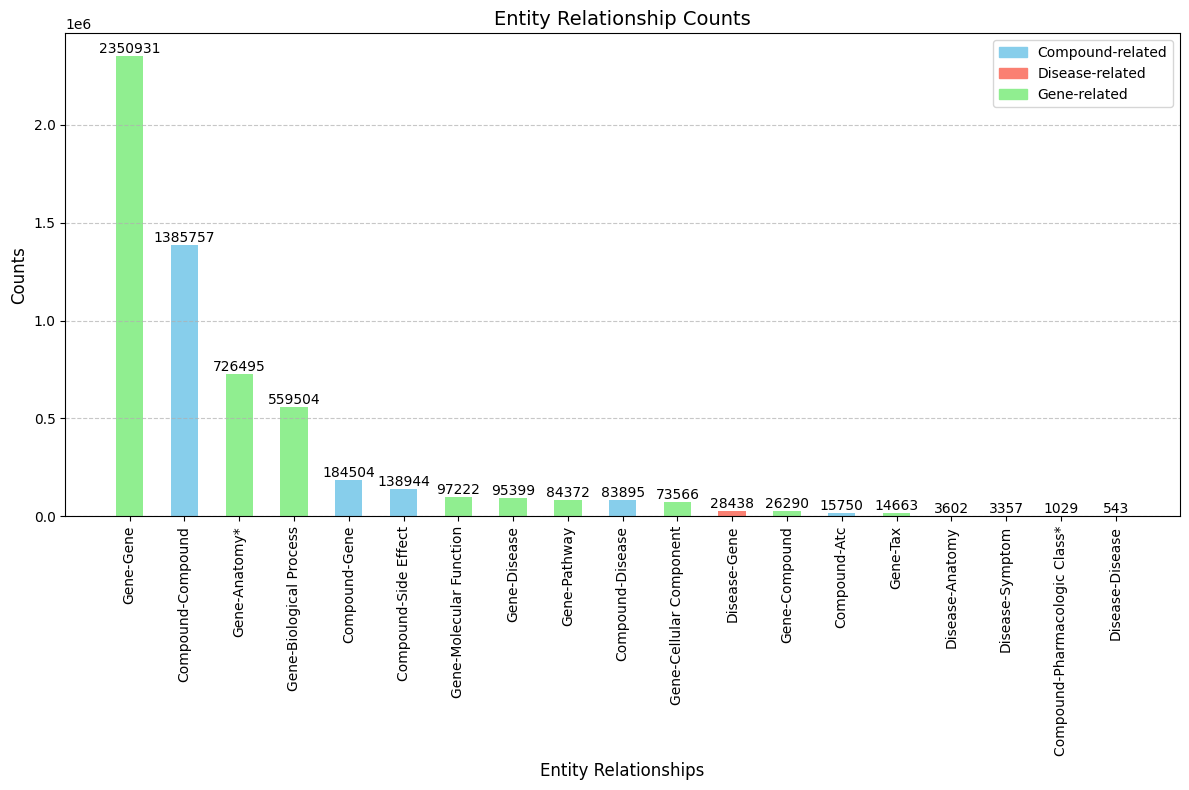

In [ ]:
import matplotlib.pyplot as plt

colors = []

for key in list(valid_counts.keys()):
    if key.split('-')[0] == "Compound":
        colors.append('skyblue')
    elif key.split('-')[0] == "Disease":
        colors.append('salmon')
    else:
        colors.append('lightgreen')

plt.figure(figsize=(12, 8))
colors_dict = {"Compound-related": "skyblue", "Disease-related": "salmon", "Gene-related": "lightgreen"}

bar_width = 0.5
bars = plt.bar(valid_counts.keys(), valid_counts.values(), color=colors, width=bar_width)

for bar in bars:
    yval = bar.get_height()
    if yval:
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.xlabel('Entity Relationships', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Entity Relationship Counts', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

legend_labels = [plt.Rectangle((0, 0), 1, 1, color=colors_dict[key]) for key in colors_dict]
plt.legend(legend_labels, colors_dict.keys())

plt.tight_layout()
plt.show()

### Homogeneous Relation Analysis:

*   Gene
*   Disease
*   Compound

In [ ]:
def plot_relation_type_counts(key):
    relations = df[df.relation_entities == key]
    if relations.shape[0] == 0:
        print(f"No relations found between {key}.")
        return

    rel_counts = Counter(relations.relation_type)
    rel_counts = {k: v for k, v in sorted(rel_counts.items(), key=lambda item: item[1], reverse=True)}

    plt.figure(figsize=(12, 12))

    bar_width = 0.5
    bars = plt.bar(rel_counts.keys(), rel_counts.values(), width=bar_width, color=colors_dict[f"{key.split('-')[0]}-related"])

    for bar in bars:
        yval = bar.get_height()
        if yval:
            plt.text(bar.get_x() + bar.get_width()/2, yval+max(rel_counts.values())/80, round(yval, 1), ha='center', va='bottom', rotation=90)

    plt.xlabel('Relationship Type', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title(f'{key} Relationships', fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=10)
    plt.ylim(0, max(rel_counts.values())*1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    rels = rel_df[rel_df['Connected entity-types']==f"{key.split('-')[0]}:{key.split('-')[1]}"]
    if rels.shape[0]:
        print(f"Explanation for the relationship types:")
        for r in range(rels.shape[0]):
            if pd.isna(rels.iloc[r]['Description']):
                print(f"{r+1}.\t{rels.iloc[r]['Relation-name'].split(':')[2]} ({rels.iloc[r]['Interaction-type']})")
            else:
                print(f"{r+1}.\t{rels.iloc[r]['Relation-name'].split(':')[2]} ({rels.iloc[r]['Interaction-type']}) - {rels.iloc[r]['Description']}")

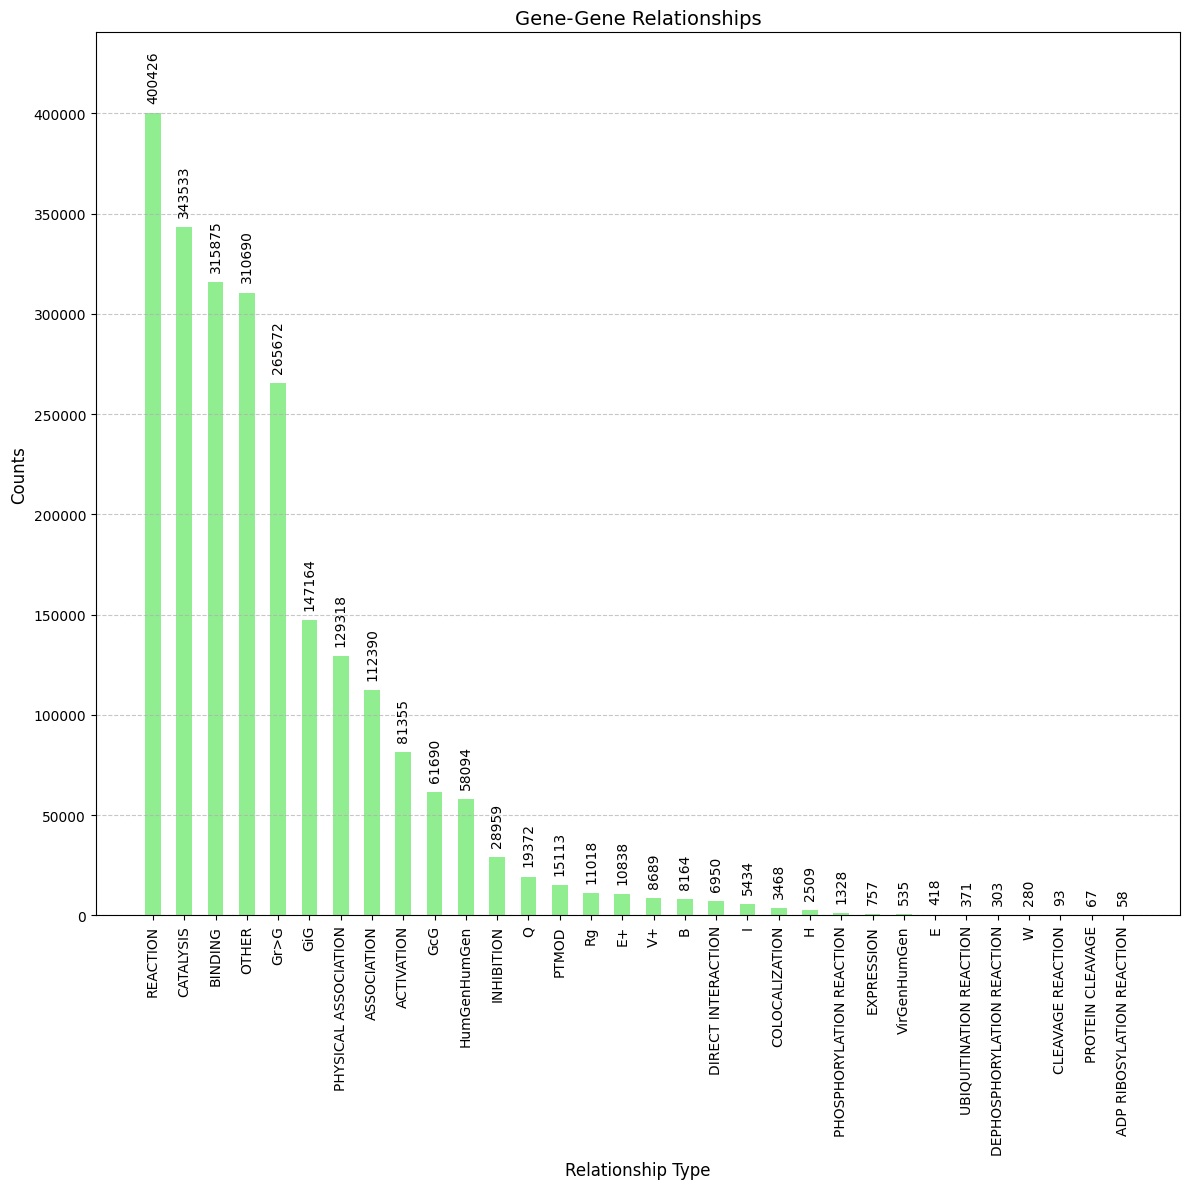

Explanation for the relationship types:
1.	B (binding, ligand (esp. receptors))
2.	E+ (increases expression/production)
3.	E (affects expression/production (neutral))
4.	H (same protein or complex)
5.	I (signaling pathway)
6.	Q (production by cell population)
7.	Rg (regulation)
8.	V+ (activates, stimulates)
9.	W (enhances response)
10.	GcG (covariation)
11.	GiG (interaction)
12.	Gr>G (regulation)
13.	ADP RIBOSYLATION REACTION (ADP ribosylation reaction) - Involves the addition of one or more ADP-ribose moieties to proteins.
14.	ASSOCIATION (association) - Interaction between molecules that may participate in formation of one, but possibly more, physical complexes.
15.	CLEAVAGE REACTION (cleavage reaction) - Covalent bond breakage in a molecule leading to the formation of smaller molecules.
16.	COLOCALIZATION (colocalization) - Coincident occurrence of molecules in a given subcellular fraction observed with a low resolution methodology from which a physical interaction among those molec

In [ ]:
plot_relation_type_counts("Gene-Gene")

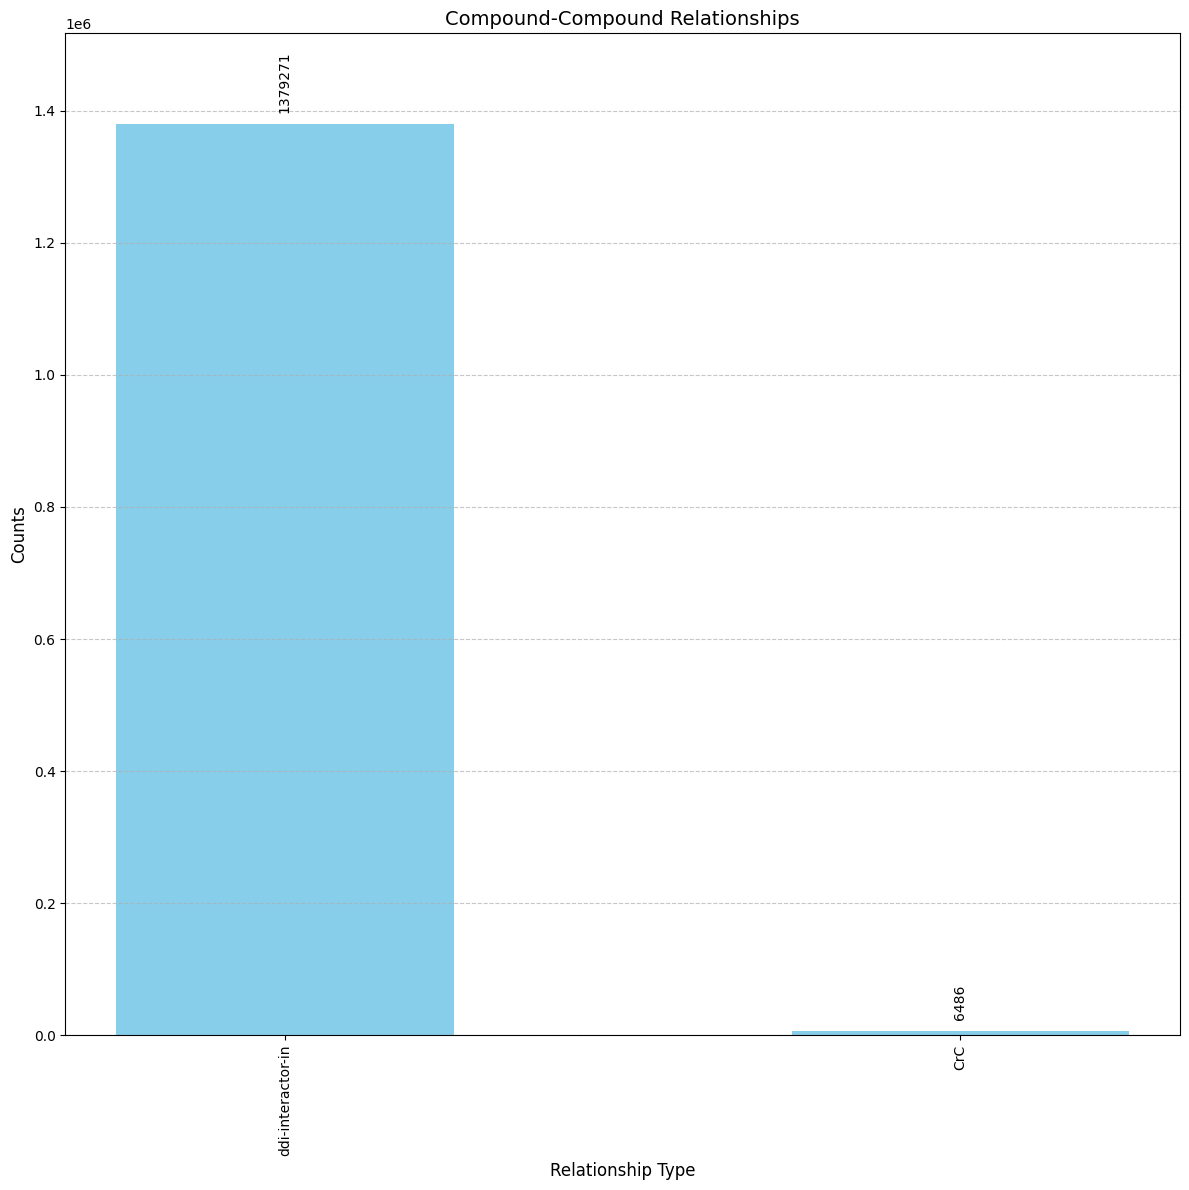

Explanation for the relationship types:
1.	ddi-interactor-in (drug-drug interaction) - In DrugBank, this relation refers to a change in a drug's effect on the body when the drug is taken with other drugs.
2.	CrC (resemblence)


In [ ]:
plot_relation_type_counts("Compound-Compound")

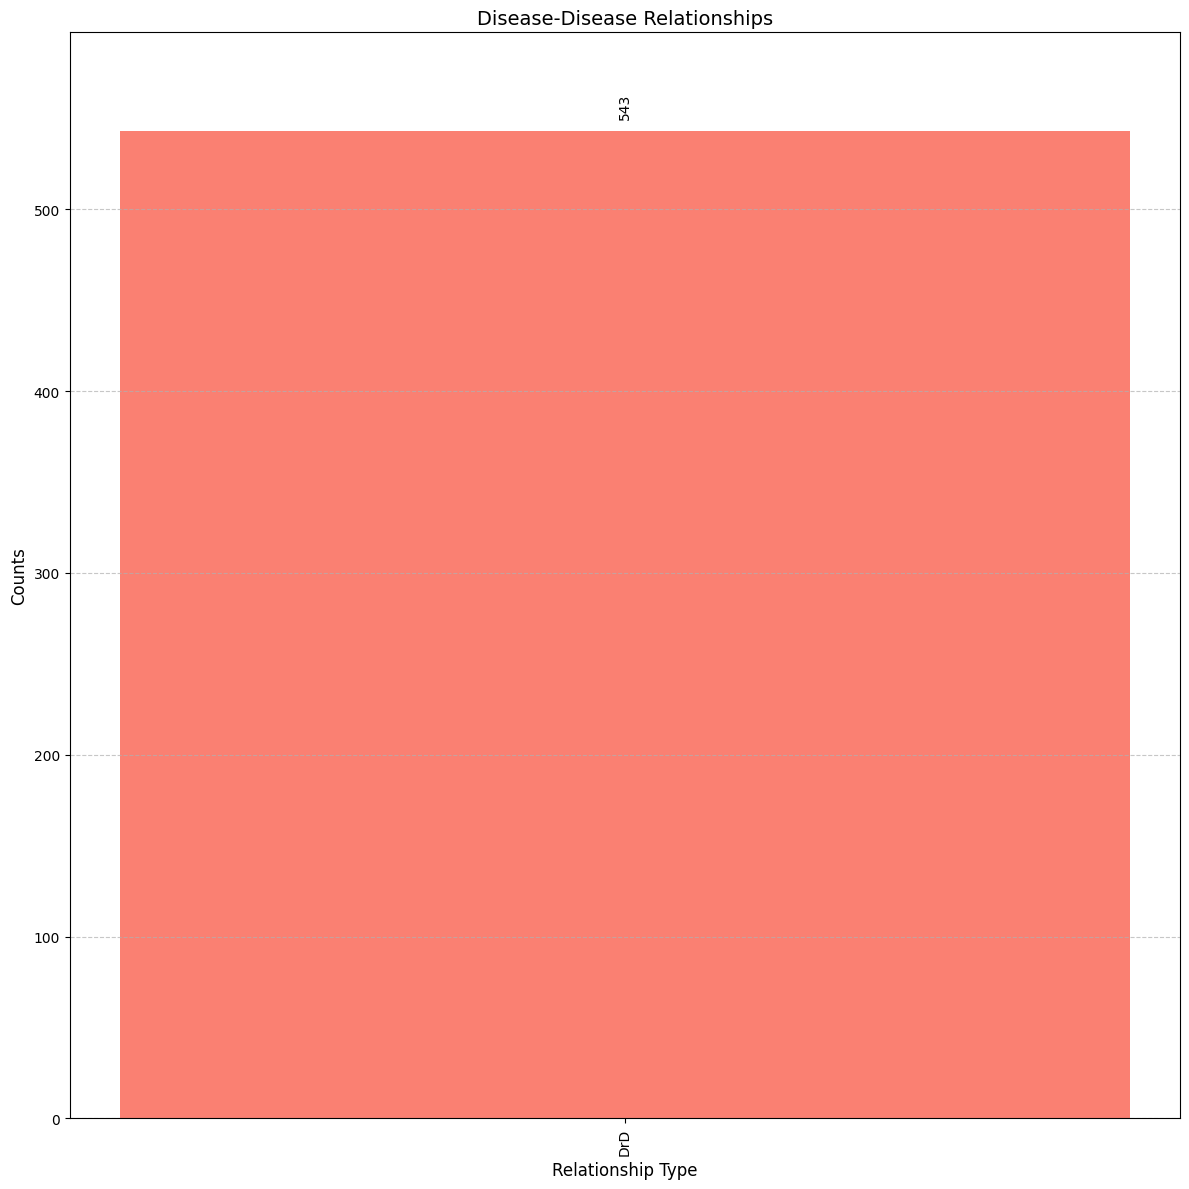

In [ ]:
plot_relation_type_counts("Disease-Disease")

### Heterogeneous Relation Analysis:

*   Gene-Disease
*   Disease-Compound
*   Compound-Gene

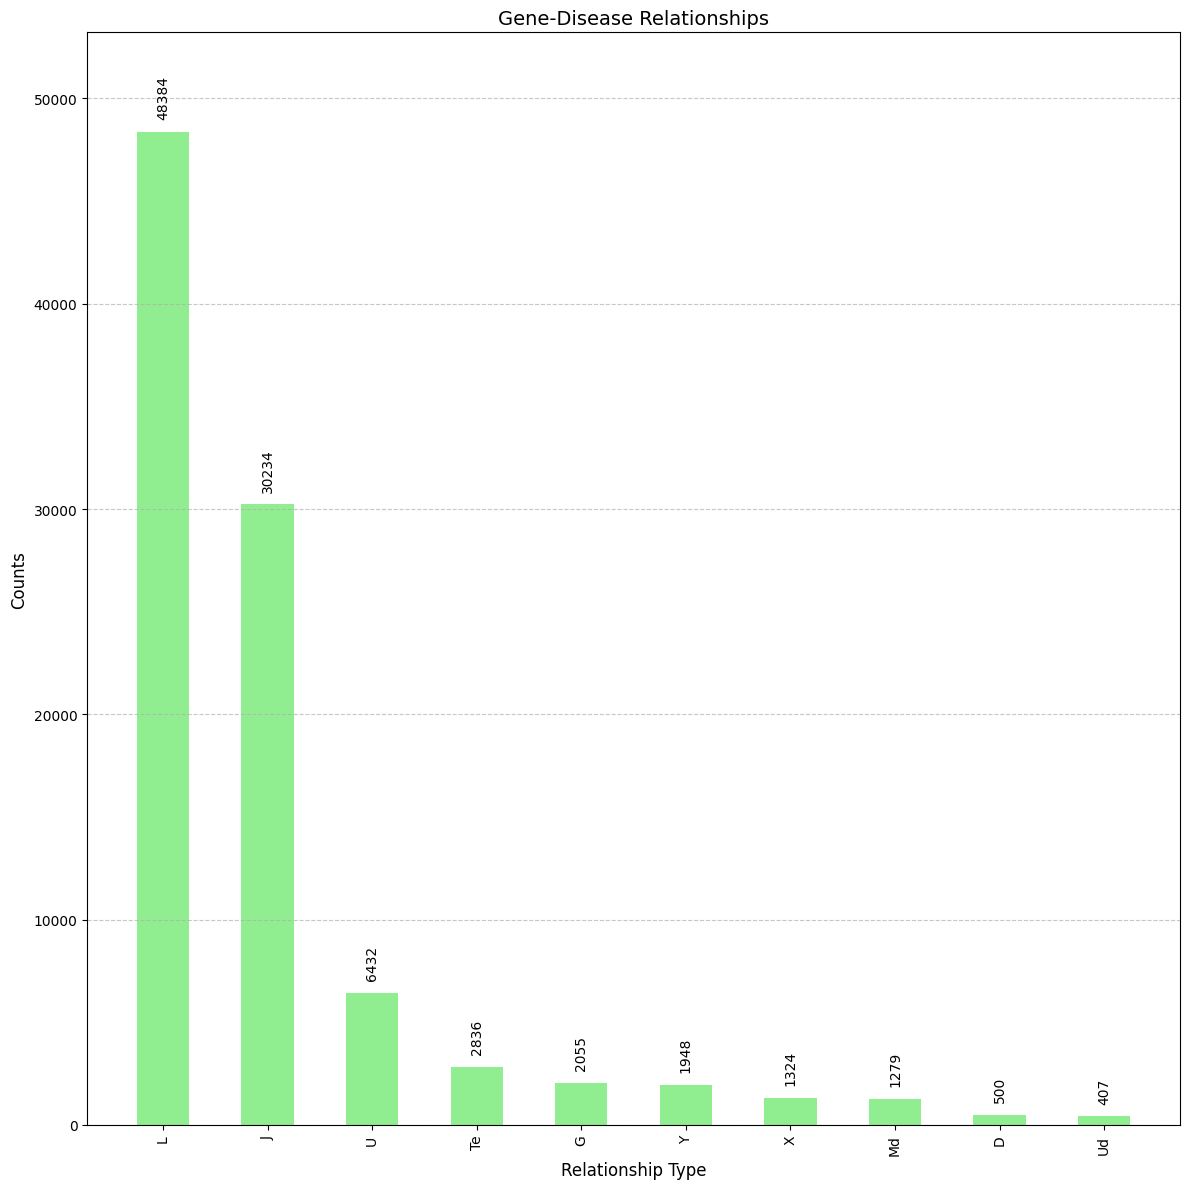

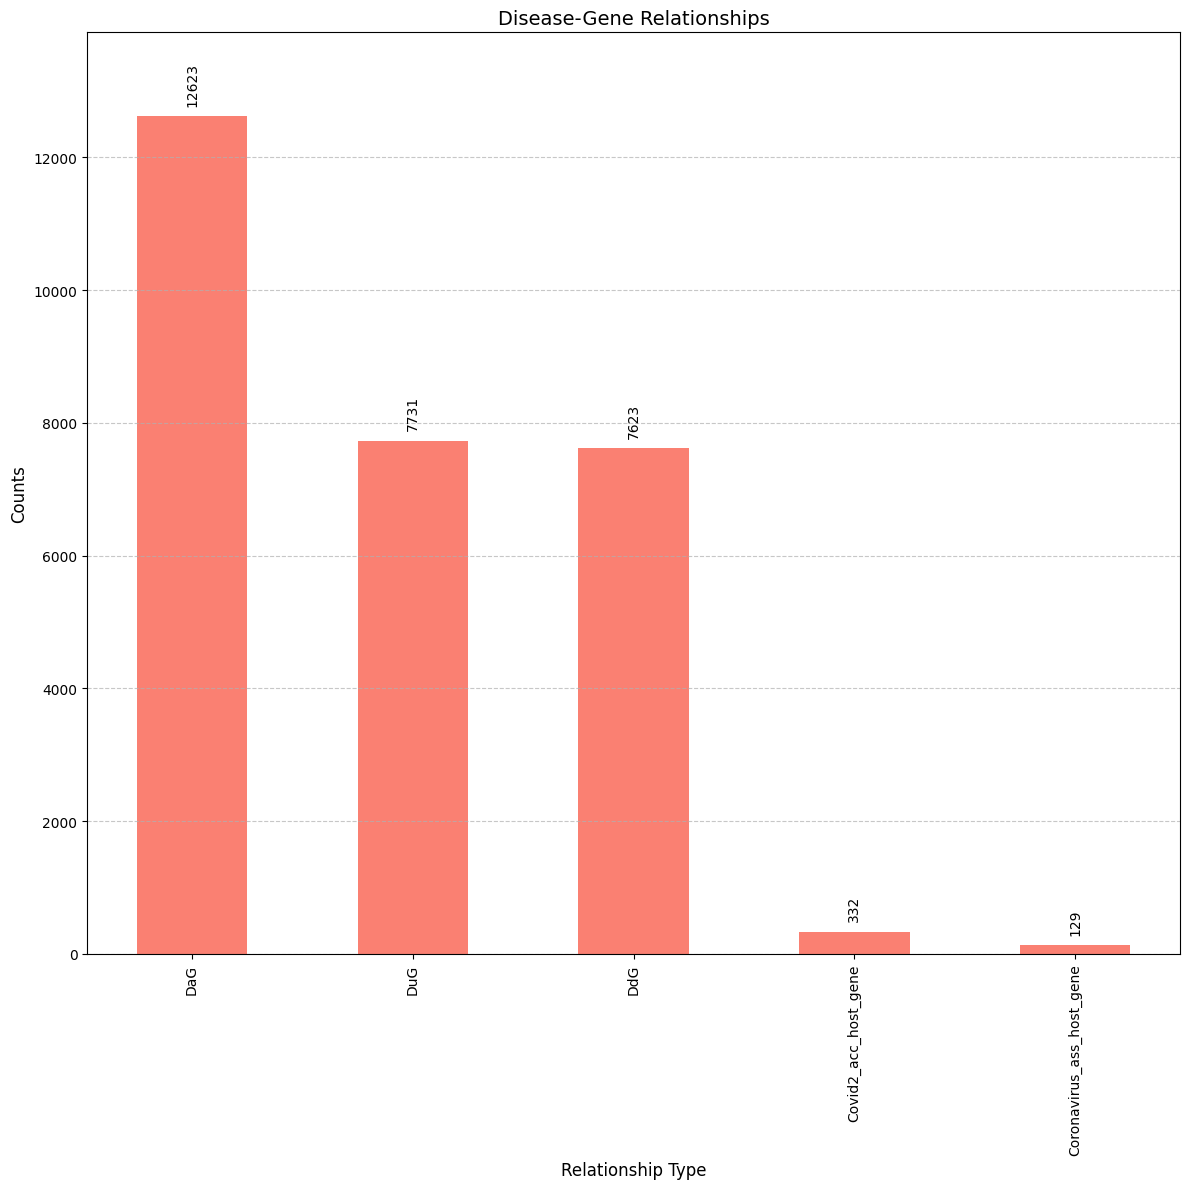

Explanation for the relationship types:
1.	D (drug targets)
2.	G (promotes progression)
3.	J (role in pathogenesis)
4.	L (improper regulation linked to disease)
5.	Md (biomarkers (diagnostic))
6.	Te (possible therapeutic effect)
7.	U (causal mutations)
8.	Ud (mutations affecting disease course)
9.	X (overexpression in disease)
10.	Y (polymorphisms alter risk)
11.	DaG (association)
12.	DdG (downregulation)
13.	DuG (upregulation)
14.	Coronavirus_ass_host_gene (interaction) - Interactions between the 6 Covid-19 related  diseases namely IBV, HCoV-229E, HCoV-NL63, SARS, MERS and MHV, and 117 host proteins.
15.	Covid2_acc_host_gene (interaction) - Interactions between 27 viral  proteins,  and 332 physically associated human genes.


In [ ]:
plot_relation_type_counts("Gene-Disease")
plot_relation_type_counts("Disease-Gene")

No relations found between Disease-Compound.


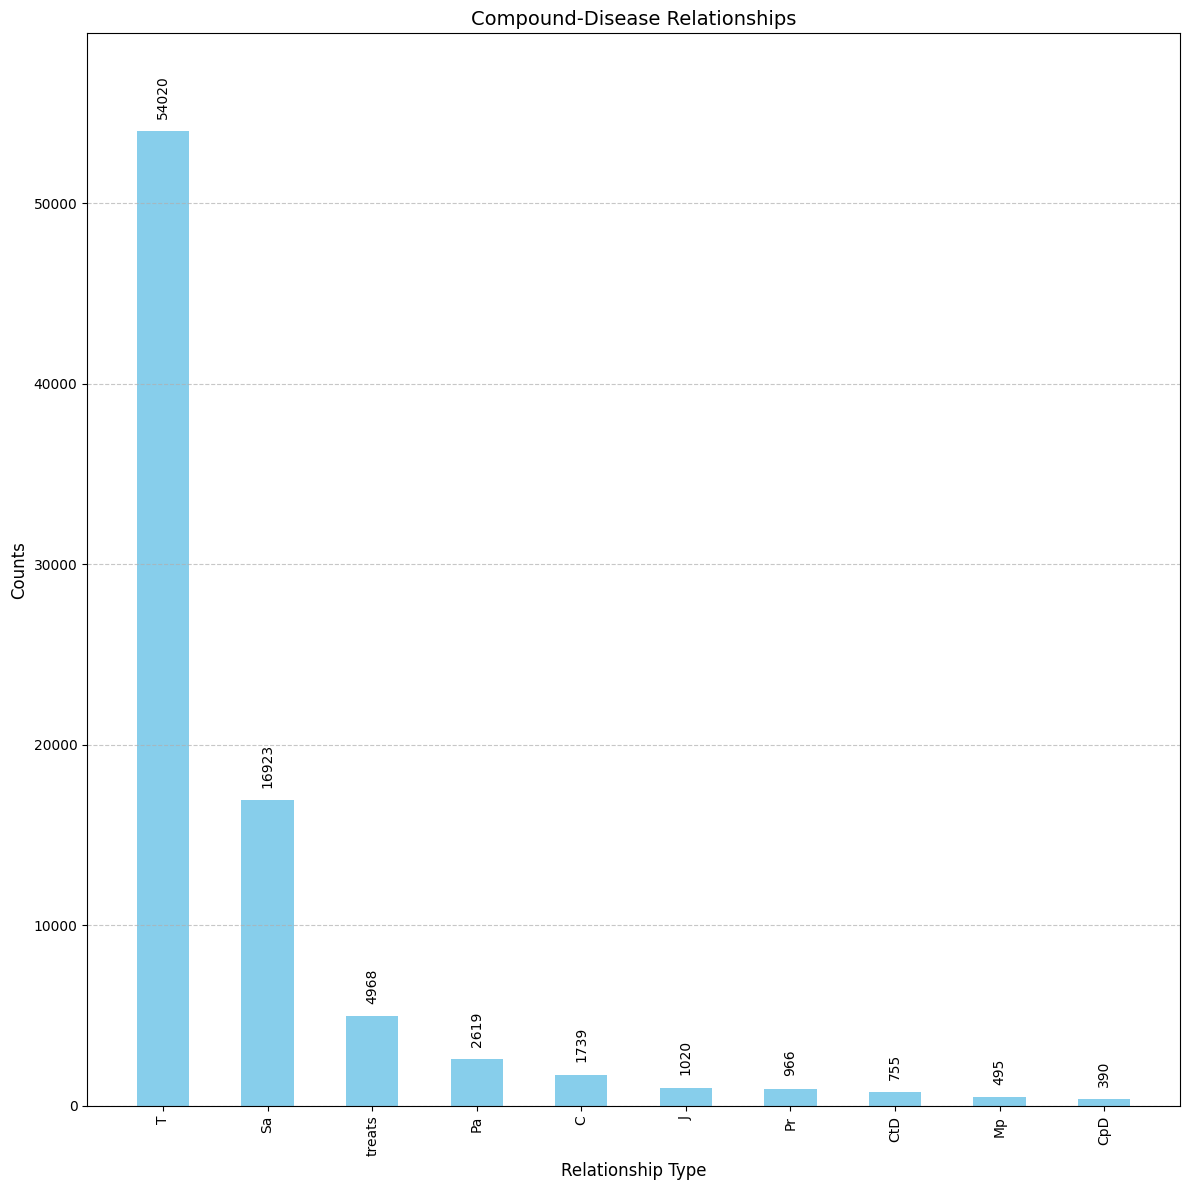

Explanation for the relationship types:
1.	treats (Compound treats the disease) - We extract  the  associated  conditions  related  to  compound entities in the drugbank.
2.	C (inhibits cell growth (esp. cancers))
3.	J (role in disease pathogenesis)
4.	Mp (biomarkers (of disease progression))
5.	Pa (alleviates, reduces)
6.	Pr (prevents, suppresses)
7.	Sa (side effect/adverse event)
8.	T (treatment/therapy (including investigatory))
9.	CpD (palliation)
10.	CtD (treatment)


In [ ]:
plot_relation_type_counts("Disease-Compound")
plot_relation_type_counts("Compound-Disease")

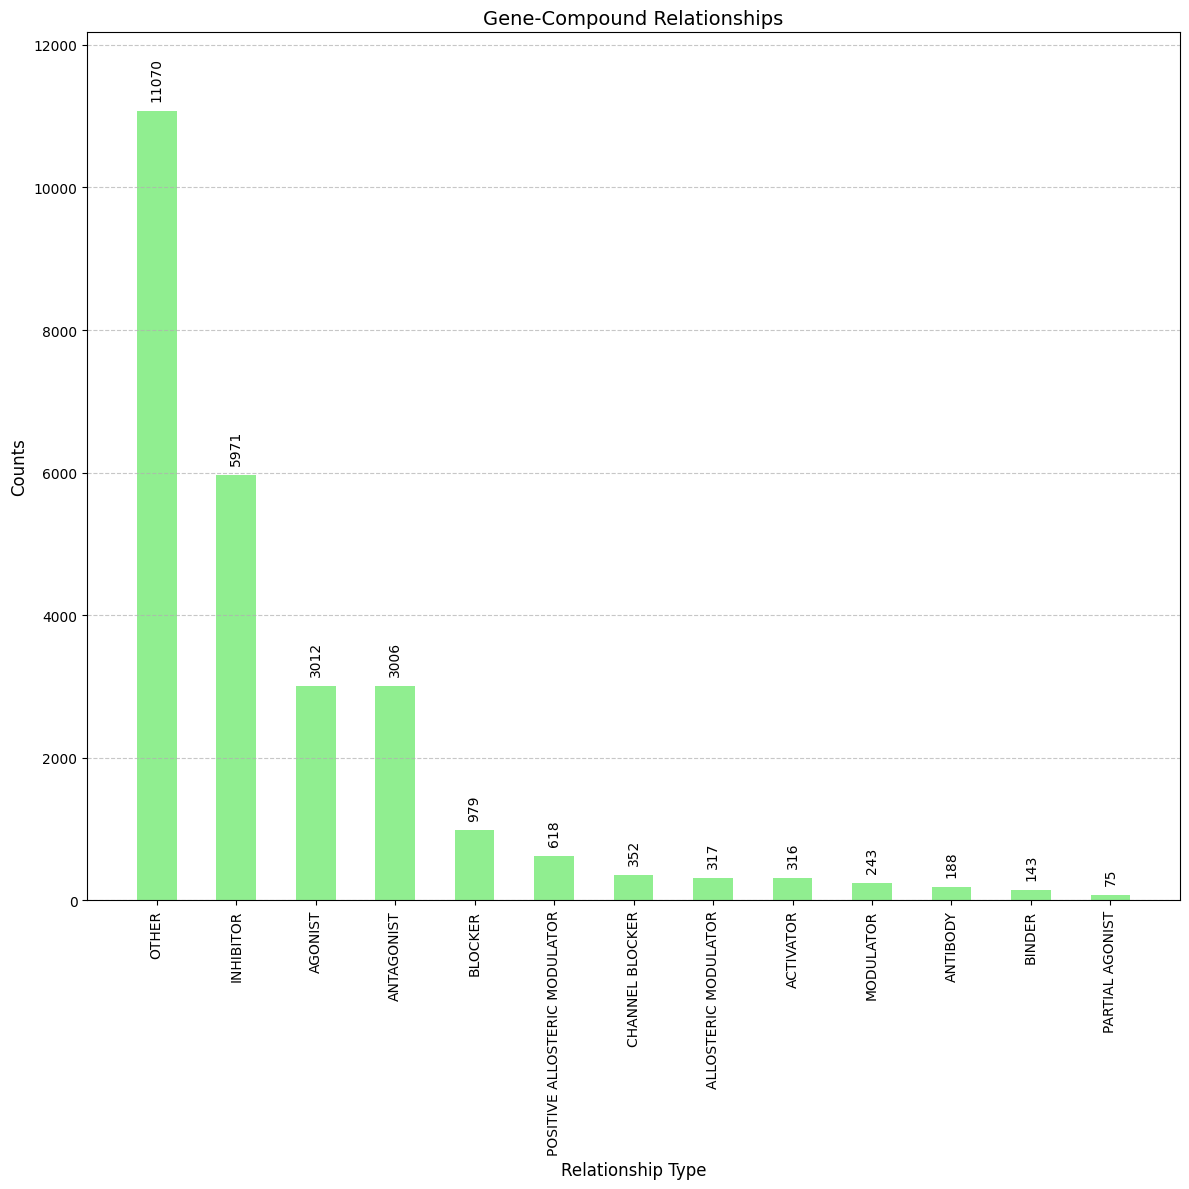

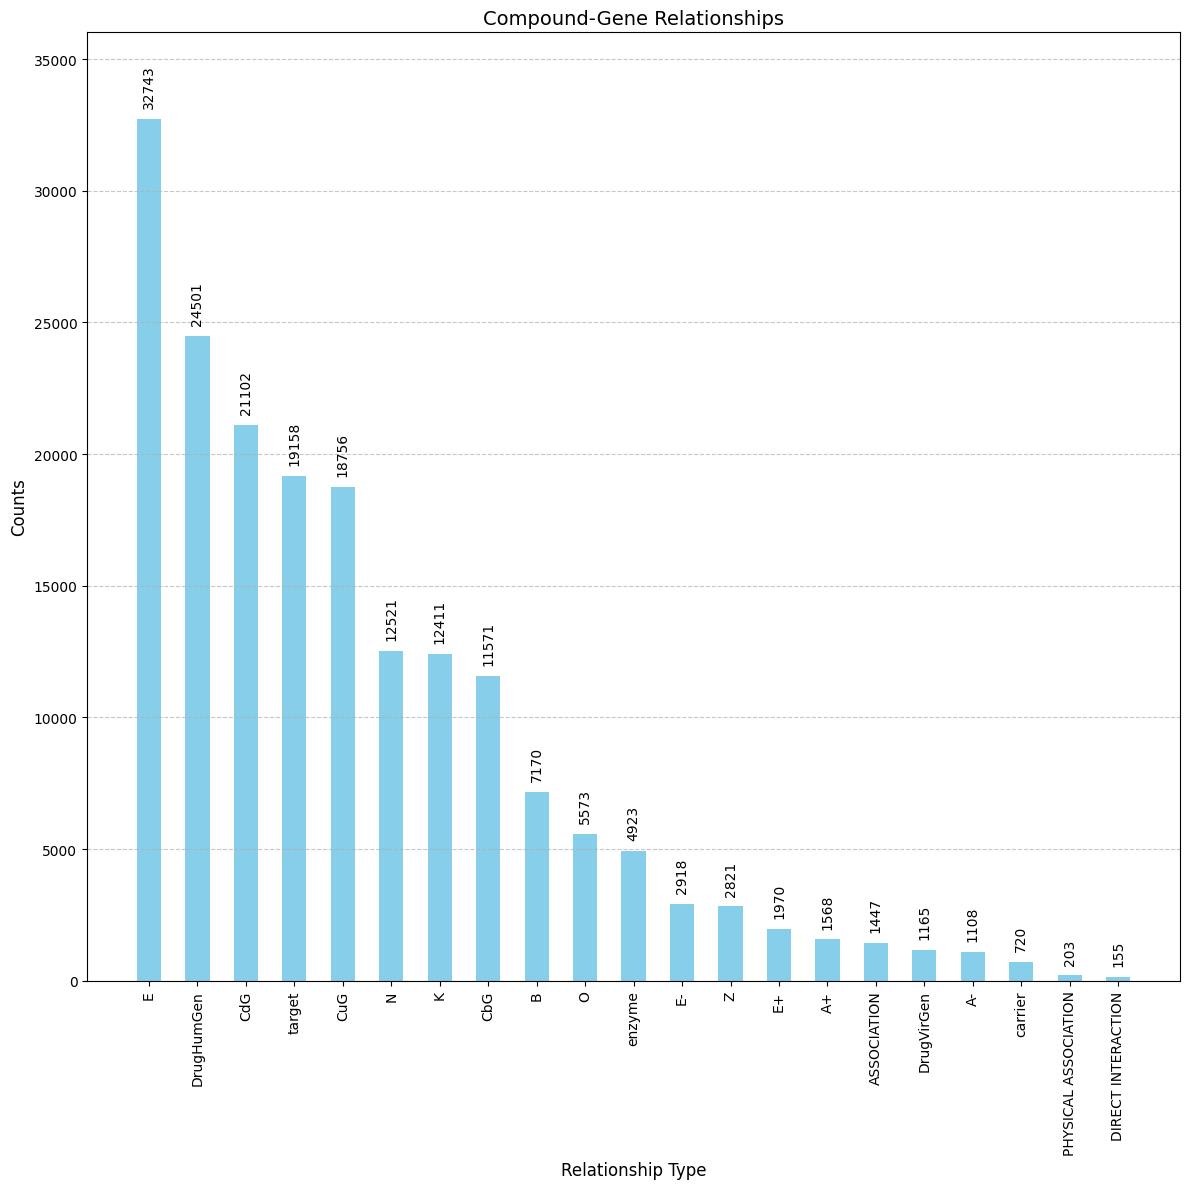

Explanation for the relationship types:
1.	ACTIVATOR (activation) - An activator interaction is when a drug activates a biological response from a target, although the mechanism by which it does so may not be understood.
2.	AGONIST (agonism) - An agonist interaction occurs when a drug binds to a target receptor and activates the receptor to produce a biological response.
3.	ALLOSTERIC MODULATOR (allosteric modulation) - An allosteric modulator interaction occurs when drugs exert their effects on their protein targets via a different binding site than the natural (orthosteric) ligand site.
4.	ANTAGONIST (antagonism) - An antagonist interaction occurs when a drug blocks or dampens agonist-mediated responses rather than provoking a biological response itself upon binding to a target receptor.
5.	ANTIBODY (antibody) - An antibody interaction occurs when an antibody drug specifically binds the target molecule.
6.	BINDER (binding) - A binder interaction has drugs physically binding to their 

In [ ]:
plot_relation_type_counts("Gene-Compound")
plot_relation_type_counts("Compound-Gene")